In [1]:
import pandas as pd
# glob module for wildcards in paths
import glob
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import math
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [16]:
def check_event_structure(events):
    events = events.reset_index(drop=True)
    stack = []
    error_indices = []

    for i, val in events.items():
        if val in [1, 2]:
            stack.append((val, i))

        elif val in [-1, -2]:
            if not stack:
                # One-liner closing code: allow only if surrounded by non-NaNs
                before_valid = (i > 0) and not pd.isna(events.iloc[i - 1])
                after_valid = (i < len(events) - 1) and not pd.isna(events.iloc[i + 1])
                if not (before_valid or after_valid):
                    error_indices.append(i)
            else:
                open_val, open_idx = stack.pop()
                if open_val + val != 0:
                    error_indices.extend([open_idx, i])  # mismatched start-end pair
                elif not events.iloc[open_idx+1:i].isna().all():
                    # non-NaNs in between a valid start and end
                    error_indices.extend(events.iloc[open_idx+1:i].dropna().index.tolist())

    # Remaining unclosed events
    for _, open_idx in stack:
        error_indices.append(open_idx)

    return sorted(set(error_indices))


In [28]:
def display_event_windows_highlight(df, bad_indices, window=4, column='events'):
    for idx in bad_indices:
        start = max(idx - window, 0)
        end = min(idx + window + 1, len(df))
        window_df = df.loc[start:end].copy()

        # Highlight the row with the bad index
        def highlight_row(row):
            if row.name == idx:
                return ['background-color: lightcoral'] * len(row)
            else:
                return [''] * len(row)

        print(f"\n--- Context around index {idx} ---")
        display(window_df.style.apply(highlight_row, axis=1))



In [2]:
input_file = "/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/Complete_Data_AngularV.cvs"

In [3]:
Experiment_1 = pd.read_csv(input_file)

In [4]:
Experiment_1.head()

,Unnamed: 0,index,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,...,thresh,isFix,corrected_vel,events,length,distance,avg_dist,names,Collider_CategoricalN,Unnamed: 0.2
0,0,0,365,1,1,1.635519e+09,1.0,1.0,3.333588,3.785751,...,44.460563,NaN,NaN,NaN,NaN,NaN,NaN,Building_161,Building,NaN
1,1,1,365,1,1,1.635519e+09,1.0,1.0,3.291748,3.744843,...,44.460563,0.000000,NaN,2.0,0.672079,63.996796,63.996938,Building_161,Building,NaN
2,2,2,365,1,1,1.635519e+09,1.0,1.0,3.291748,3.744843,...,44.460563,0.000000,NaN,NaN,0.672079,63.996796,63.996938,Building_161,Building,NaN
3,3,3,365,1,1,1.635519e+09,1.0,1.0,3.259613,3.707169,...,44.460563,73.369491,NaN,NaN,0.672079,63.997106,63.996938,Building_161,Building,NaN
4,4,4,365,1,1,1.635519e+09,1.0,1.0,3.259613,3.707169,...,44.460563,0.642210,0.64221,NaN,0.672079,63.997107,63.996938,Building_161,Building,NaN


In [5]:
Experiment_1 = Experiment_1.loc[:, ~Experiment_1.columns.str.contains('^Unnamed', case=False)]

In [15]:
Experiment_1.head(55)

,index,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,...,combined_vel,thresh,isFix,corrected_vel,events,length,distance,avg_dist,names,Collider_CategoricalN
0,0,365,1,1,1.635519e+09,1.0,1.0,3.333588,3.785751,31,...,NaN,44.460563,NaN,NaN,NaN,NaN,NaN,NaN,Building_161,Building
1,1,365,1,1,1.635519e+09,1.0,1.0,3.291748,3.744843,31,...,0.000000,44.460563,0.000000,NaN,2.0,0.672079,63.996796,63.996938,Building_161,Building
2,2,365,1,1,1.635519e+09,1.0,1.0,3.291748,3.744843,31,...,0.000000,44.460563,0.000000,NaN,NaN,0.672079,63.996796,63.996938,Building_161,Building
3,3,365,1,1,1.635519e+09,1.0,1.0,3.259613,3.707169,31,...,73.369491,44.460563,73.369491,NaN,NaN,0.672079,63.997106,63.996938,Building_161,Building
4,4,365,1,1,1.635519e+09,1.0,1.0,3.259613,3.707169,31,...,0.642210,44.460563,0.642210,0.642210,NaN,0.672079,63.997107,63.996938,Building_161,Building
5,5,365,1,1,1.635519e+09,1.0,1.0,3.207932,3.690155,31,...,0.545318,44.460563,0.545318,0.545318,NaN,0.672079,63.997138,63.996938,Building_161,Building
6,6,365,1,1,1.635519e+09,1.0,1.0,3.184616,3.676071,31,...,9.914401,44.460563,9.914401,9.914401,NaN,0.672079,63.997138,63.996938,Building_161,Building
7,7,365,1,1,1.635519e+09,1.0,1.0,3.166901,3.659622,31,...,12.402678,44.460563,12.402678,12.402678,NaN,0.672079,63.997139,63.996938,Building_161,Building
8,8,365,1,1,1.635519e+09,1.0,1.0,3.149246,3.650574,31,...,6.839561,44.460563,6.839561,6.839561,NaN,0.672079,63.997149,63.996938,Building_161,Building
9,9,365,1,1,1.635519e+09,1.0,1.0,3.144104,3.643616,31,...,5.783798,44.460563,5.783798,5.783798,NaN,0.672079,63.997135,63.996938,Building_161,Building


In [11]:
Experiment_1.shape[0]

15879404

In [17]:
bad_indices = check_event_structure(Experiment_1['events'])

if bad_indices:
    print("Problems found at indices:", len(bad_indices))
else:
    print("All events are correctly structured.")

Problems found at indices: 4


In [27]:
bad_indices

[2222947, 2223347, 4758244, 4758907]

In [18]:
(len(bad_indices)/Experiment_1.shape[0]) *100

2.518986228954185e-05

In [29]:
context_df = display_event_windows_highlight(Experiment_1, bad_indices, window=4)


--- Context around index 2222947 ---


,index,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,rayCastHitsLeftEye,rayCastHitsRightEye,eyePositionCombinedWorld.x,eyePositionCombinedWorld.y,eyePositionCombinedWorld.z,eyeDirectionCombinedWorld.x,eyeDirectionCombinedWorld.y,eyeDirectionCombinedWorld.z,eyeDirectionCombinedLocal.x,eyeDirectionCombinedLocal.y,eyeDirectionCombinedLocal.z,eyePositionLeftWorld.x,eyePositionLeftWorld.y,eyePositionLeftWorld.z,eyeDirectionLeftWorld.x,eyeDirectionLeftWorld.y,eyeDirectionLeftWorld.z,eyeDirectionLeftLocal.x,eyeDirectionLeftLocal.y,eyeDirectionLeftLocal.z,eyePositionRightWorld.x,eyePositionRightWorld.y,eyePositionRightWorld.z,eyeDirectionRightWorld.x,eyeDirectionRightWorld.y,eyeDirectionRightWorld.z,eyeDirectionRightLocal.x,eyeDirectionRightLocal.y,eyeDirectionRightLocal.z,hmdPosition.x,hmdPosition.y,hmdPosition.z,hmdDirectionForward.x,hmdDirectionForward.y,hmdDirectionForward.z,hmdDirectionRight.x,hmdDirectionRight.y,hmdDirectionRight.z,hmdRotation.x,hmdRotation.y,hmdRotation.z,hmdDirectionUp.x,hmdDirectionUp.y,hmdDirectionUp.z,handLeftPosition.x,handLeftPosition.y,handLeftPosition.z,handLeftRotation.x,handLeftRotation.y,handLeftRotation.z,handLeftScale.x,handLeftScale.y,handLeftScale.z,handLeftDirectionForward.x,handLeftDirectionForward.y,handLeftDirectionForward.z,handLeftDirectionRight.x,handLeftDirectionRight.y,handLeftDirectionRight.z,handLeftDirectionUp.x,handLeftDirectionUp.y,handLeftDirectionUp.z,handRightPosition.x,handRightPosition.y,handRightPosition.z,handRightRotation.x,handRightRotation.y,handRightRotation.z,handRightScale.x,handRightScale.y,handRightScale.z,handRightDirectionForward.x,handRightDirectionForward.y,handRightDirectionForward.z,handRightDirectionRight.x,handRightDirectionRight.y,handRightDirectionRight.z,handRightDirectionUp.x,handRightDirectionUp.y,handRightDirectionUp.z,playerBodyPosition.x,playerBodyPosition.y,playerBodyPosition.z,bodyTrackerPosition.x,bodyTrackerPosition.y,bodyTrackerPosition.z,hitObjectColliderName,hitColliderType,ordinalOfHit,hitPointOnObject_x,hitPointOnObject_y,hitPointOnObject_z,Eucledian_distance,Collider_Categorical,Face_Hits,Time_Shift,Continuous_Time,Bitmask_flag,Interpolated_collider,eyePositionCombinedWorld.x,Collider_shift,counter,Time_of_Gaze,Gaze,combined_vel,thresh,isFix,corrected_vel,events,length,distance,avg_dist,names,Collider_CategoricalN
2222943,107904,2693,3,3,1655112344.063459,1.000000,1.000000,3.678421,3.347641,31,31,3,[],[],-167.411423,-0.425641,-203.627777,-0.977321,0.123620,-0.171854,0.035324,-0.181000,0.982834,-167.363739,-0.425230,-203.625000,-0.976043,0.136241,-0.169610,0.037933,-0.168564,0.984955,-167.430008,-0.425801,-203.628860,-0.977789,0.118702,-0.172727,0.034302,-0.185837,0.981979,-167.398636,-0.433237,-203.588867,-0.931199,0.299309,-0.208043,-0.201389,0.053276,0.978062,342.583893,257.406128,3.200821,0.303826,0.952668,0.010667,-166.941116,-1.936664,-203.365143,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-167.199051,-1.168815,-203.308899,43.705383,146.181259,331.699493,1.000000,1.000000,1.000000,0.402344,-0.690950,-0.600589,-0.913818,-0.342725,-0.217891,-0.055285,0.636496,-0.769296,-166.981735,-1.936664,-203.402649,0.000000,0.000000,0.000000,Castle-TaskBuilding_56,UnityEngine.BoxCollider,1.000000,-378.614227,26.269302,-240.482010,216.590271,Global_Landmark,Not_Agent,0.022321,36.090000,No_change,Castle-TaskBuilding_56,nan,False,19153.000000,nan,Movement,5.729303,24.399726,5.729303,5.729303,nan,0.188977,216.166743,216.410418,Castle-TaskBuilding_56,Global_Landmark
2222944,107905,2693,3,3,1655112344.086771,1.000000,1.000000,3.671280,3.339233,31,31,3,[],[],-167.411423,-0.425641,-203.627777,-0.977239,0.126475,-0.170238,0.036774,-0.178040,0.983322,-167.444763,-0.425209,-203.699661,-0.976508,0


--- Context around index 2223347 ---


,index,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,rayCastHitsLeftEye,rayCastHitsRightEye,eyePositionCombinedWorld.x,eyePositionCombinedWorld.y,eyePositionCombinedWorld.z,eyeDirectionCombinedWorld.x,eyeDirectionCombinedWorld.y,eyeDirectionCombinedWorld.z,eyeDirectionCombinedLocal.x,eyeDirectionCombinedLocal.y,eyeDirectionCombinedLocal.z,eyePositionLeftWorld.x,eyePositionLeftWorld.y,eyePositionLeftWorld.z,eyeDirectionLeftWorld.x,eyeDirectionLeftWorld.y,eyeDirectionLeftWorld.z,eyeDirectionLeftLocal.x,eyeDirectionLeftLocal.y,eyeDirectionLeftLocal.z,eyePositionRightWorld.x,eyePositionRightWorld.y,eyePositionRightWorld.z,eyeDirectionRightWorld.x,eyeDirectionRightWorld.y,eyeDirectionRightWorld.z,eyeDirectionRightLocal.x,eyeDirectionRightLocal.y,eyeDirectionRightLocal.z,hmdPosition.x,hmdPosition.y,hmdPosition.z,hmdDirectionForward.x,hmdDirectionForward.y,hmdDirectionForward.z,hmdDirectionRight.x,hmdDirectionRight.y,hmdDirectionRight.z,hmdRotation.x,hmdRotation.y,hmdRotation.z,hmdDirectionUp.x,hmdDirectionUp.y,hmdDirectionUp.z,handLeftPosition.x,handLeftPosition.y,handLeftPosition.z,handLeftRotation.x,handLeftRotation.y,handLeftRotation.z,handLeftScale.x,handLeftScale.y,handLeftScale.z,handLeftDirectionForward.x,handLeftDirectionForward.y,handLeftDirectionForward.z,handLeftDirectionRight.x,handLeftDirectionRight.y,handLeftDirectionRight.z,handLeftDirectionUp.x,handLeftDirectionUp.y,handLeftDirectionUp.z,handRightPosition.x,handRightPosition.y,handRightPosition.z,handRightRotation.x,handRightRotation.y,handRightRotation.z,handRightScale.x,handRightScale.y,handRightScale.z,handRightDirectionForward.x,handRightDirectionForward.y,handRightDirectionForward.z,handRightDirectionRight.x,handRightDirectionRight.y,handRightDirectionRight.z,handRightDirectionUp.x,handRightDirectionUp.y,handRightDirectionUp.z,playerBodyPosition.x,playerBodyPosition.y,playerBodyPosition.z,bodyTrackerPosition.x,bodyTrackerPosition.y,bodyTrackerPosition.z,hitObjectColliderName,hitColliderType,ordinalOfHit,hitPointOnObject_x,hitPointOnObject_y,hitPointOnObject_z,Eucledian_distance,Collider_Categorical,Face_Hits,Time_Shift,Continuous_Time,Bitmask_flag,Interpolated_collider,eyePositionCombinedWorld.x,Collider_shift,counter,Time_of_Gaze,Gaze,combined_vel,thresh,isFix,corrected_vel,events,length,distance,avg_dist,names,Collider_CategoricalN
2223343,397,2693,4,1,1655194373.282691,0.184544,0.100000,-1.000000,-1.000000,24,25,0,[],[],-59.212044,2.421578,34.537182,-0.301336,-1.157953,1.252334,1.000000,-1.000000,-1.000000,-59.174168,2.419630,34.537880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-59.244503,2.420518,34.536667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-59.211227,2.418689,34.574417,-0.571464,0.137302,-0.809060,-0.818852,-0.030594,0.573188,352.108246,215.234726,358.230042,0.053947,0.990057,0.129914,-59.099869,0.858863,34.795731,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-59.344467,2.096331,34.479622,280.735291,176.894058,53.273224,1.000000,1.000000,1.000000,0.010093,0.982498,-0.185998,-0.639788,0.149296,0.753911,0.768485,0.111390,0.630098,-59.099869,0.858863,34.795731,0.000000,0.000000,0.000000,road_base_network.004,UnityEngine.MeshCollider,1.000000,-100.031929,1.999696,8.298313,nan,Background,Not_Agent,0.011408,0.168000,-0.423858642578125,road_base_network.004,nan,False,143.000000,nan,Movement,nan,63.557533,nan,nan,nan,10.123350,311.858066,311.933960,Crane_59,Global_Landmark
2223344,398,2693,4,1,1655194373.304019,0.255717,0.100000,-1.000000,-1.000000,24,25,0,[],[],-59.212044,2.421663,34.536535,-0.274836,-1.168972,1.248187,1.000000,-1.000000,-1.000000,-59.174656,2.419943,34.536873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-59.244915,2.420908,34.535542,0.000000,0


--- Context around index 4758244 ---


,index,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,rayCastHitsLeftEye,rayCastHitsRightEye,eyePositionCombinedWorld.x,eyePositionCombinedWorld.y,eyePositionCombinedWorld.z,eyeDirectionCombinedWorld.x,eyeDirectionCombinedWorld.y,eyeDirectionCombinedWorld.z,eyeDirectionCombinedLocal.x,eyeDirectionCombinedLocal.y,eyeDirectionCombinedLocal.z,eyePositionLeftWorld.x,eyePositionLeftWorld.y,eyePositionLeftWorld.z,eyeDirectionLeftWorld.x,eyeDirectionLeftWorld.y,eyeDirectionLeftWorld.z,eyeDirectionLeftLocal.x,eyeDirectionLeftLocal.y,eyeDirectionLeftLocal.z,eyePositionRightWorld.x,eyePositionRightWorld.y,eyePositionRightWorld.z,eyeDirectionRightWorld.x,eyeDirectionRightWorld.y,eyeDirectionRightWorld.z,eyeDirectionRightLocal.x,eyeDirectionRightLocal.y,eyeDirectionRightLocal.z,hmdPosition.x,hmdPosition.y,hmdPosition.z,hmdDirectionForward.x,hmdDirectionForward.y,hmdDirectionForward.z,hmdDirectionRight.x,hmdDirectionRight.y,hmdDirectionRight.z,hmdRotation.x,hmdRotation.y,hmdRotation.z,hmdDirectionUp.x,hmdDirectionUp.y,hmdDirectionUp.z,handLeftPosition.x,handLeftPosition.y,handLeftPosition.z,handLeftRotation.x,handLeftRotation.y,handLeftRotation.z,handLeftScale.x,handLeftScale.y,handLeftScale.z,handLeftDirectionForward.x,handLeftDirectionForward.y,handLeftDirectionForward.z,handLeftDirectionRight.x,handLeftDirectionRight.y,handLeftDirectionRight.z,handLeftDirectionUp.x,handLeftDirectionUp.y,handLeftDirectionUp.z,handRightPosition.x,handRightPosition.y,handRightPosition.z,handRightRotation.x,handRightRotation.y,handRightRotation.z,handRightScale.x,handRightScale.y,handRightScale.z,handRightDirectionForward.x,handRightDirectionForward.y,handRightDirectionForward.z,handRightDirectionRight.x,handRightDirectionRight.y,handRightDirectionRight.z,handRightDirectionUp.x,handRightDirectionUp.y,handRightDirectionUp.z,playerBodyPosition.x,playerBodyPosition.y,playerBodyPosition.z,bodyTrackerPosition.x,bodyTrackerPosition.y,bodyTrackerPosition.z,hitObjectColliderName,hitColliderType,ordinalOfHit,hitPointOnObject_x,hitPointOnObject_y,hitPointOnObject_z,Eucledian_distance,Collider_Categorical,Face_Hits,Time_Shift,Continuous_Time,Bitmask_flag,Interpolated_collider,eyePositionCombinedWorld.x,Collider_shift,counter,Time_of_Gaze,Gaze,combined_vel,thresh,isFix,corrected_vel,events,length,distance,avg_dist,names,Collider_CategoricalN
4758240,116253,4176,5,3,1639497284.279221,0.971331,0.960952,3.659637,3.860397,31,31,3,[],[],53.137375,1.004557,1.548898,-0.012315,-0.033601,-0.999355,-0.077866,-0.067459,0.994675,53.137375,1.004557,1.548898,-0.012315,-0.033601,-0.999355,-0.077866,-0.067459,0.994675,53.073635,1.005471,1.552263,-0.024708,-0.035660,-0.999051,-0.065628,-0.070236,0.995361,53.104019,1.002363,1.578400,-0.086227,0.038264,-0.995540,-0.994522,0.055960,0.088289,357.807098,184.950195,3.210290,0.059089,0.997699,0.033229,53.052002,-0.592731,1.704025,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,52.720749,0.271880,1.433670,1.108563,187.383530,67.659355,1.000000,1.000000,1.000000,-0.128486,-0.019347,-0.991523,-0.379260,0.924767,0.031102,0.916326,0.380041,-0.126157,53.016479,-0.593536,1.659790,0.000000,0.000000,0.000000,CollisionObject0,UnityEngine.CapsuleCollider,1.000000,52.516731,-1.318408,-48.817848,50.480202,Background,Not_Agent,0.022321,32.127000,No_change,CollisionObject0,nan,True,21369.000000,nan,Movement,287.560386,22.346544,nan,287.560386,nan,0.088784,50.197024,50.218217,SmallWall_21,Background
4758241,116254,4176,5,3,1639497284.301539,1.000000,1.000000,3.696808,3.802673,31,31,3,[],[],53.137375,1.004557,1.548898,-0.059181,-0.037533,-0.997527,-0.030334,-0.075455,0.996674,53.066650,1.002984,1.461926,-0.059181,-0.037533,-0.997527,-0.030334,-0.075455,0.996674,53.002941,1.004074,1.464657,-0.05572


--- Context around index 4758907 ---


,index,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,rayCastHitsLeftEye,rayCastHitsRightEye,eyePositionCombinedWorld.x,eyePositionCombinedWorld.y,eyePositionCombinedWorld.z,eyeDirectionCombinedWorld.x,eyeDirectionCombinedWorld.y,eyeDirectionCombinedWorld.z,eyeDirectionCombinedLocal.x,eyeDirectionCombinedLocal.y,eyeDirectionCombinedLocal.z,eyePositionLeftWorld.x,eyePositionLeftWorld.y,eyePositionLeftWorld.z,eyeDirectionLeftWorld.x,eyeDirectionLeftWorld.y,eyeDirectionLeftWorld.z,eyeDirectionLeftLocal.x,eyeDirectionLeftLocal.y,eyeDirectionLeftLocal.z,eyePositionRightWorld.x,eyePositionRightWorld.y,eyePositionRightWorld.z,eyeDirectionRightWorld.x,eyeDirectionRightWorld.y,eyeDirectionRightWorld.z,eyeDirectionRightLocal.x,eyeDirectionRightLocal.y,eyeDirectionRightLocal.z,hmdPosition.x,hmdPosition.y,hmdPosition.z,hmdDirectionForward.x,hmdDirectionForward.y,hmdDirectionForward.z,hmdDirectionRight.x,hmdDirectionRight.y,hmdDirectionRight.z,hmdRotation.x,hmdRotation.y,hmdRotation.z,hmdDirectionUp.x,hmdDirectionUp.y,hmdDirectionUp.z,handLeftPosition.x,handLeftPosition.y,handLeftPosition.z,handLeftRotation.x,handLeftRotation.y,handLeftRotation.z,handLeftScale.x,handLeftScale.y,handLeftScale.z,handLeftDirectionForward.x,handLeftDirectionForward.y,handLeftDirectionForward.z,handLeftDirectionRight.x,handLeftDirectionRight.y,handLeftDirectionRight.z,handLeftDirectionUp.x,handLeftDirectionUp.y,handLeftDirectionUp.z,handRightPosition.x,handRightPosition.y,handRightPosition.z,handRightRotation.x,handRightRotation.y,handRightRotation.z,handRightScale.x,handRightScale.y,handRightScale.z,handRightDirectionForward.x,handRightDirectionForward.y,handRightDirectionForward.z,handRightDirectionRight.x,handRightDirectionRight.y,handRightDirectionRight.z,handRightDirectionUp.x,handRightDirectionUp.y,handRightDirectionUp.z,playerBodyPosition.x,playerBodyPosition.y,playerBodyPosition.z,bodyTrackerPosition.x,bodyTrackerPosition.y,bodyTrackerPosition.z,hitObjectColliderName,hitColliderType,ordinalOfHit,hitPointOnObject_x,hitPointOnObject_y,hitPointOnObject_z,Eucledian_distance,Collider_Categorical,Face_Hits,Time_Shift,Continuous_Time,Bitmask_flag,Interpolated_collider,eyePositionCombinedWorld.x,Collider_shift,counter,Time_of_Gaze,Gaze,combined_vel,thresh,isFix,corrected_vel,events,length,distance,avg_dist,names,Collider_CategoricalN
4758903,660,4796,1,1,1651224986.518883,0.784300,0.759529,3.265259,2.929550,31,31,3,[],[],-49.804417,2.477209,40.312607,0.854489,-0.135738,0.501416,0.109192,-0.219086,0.969574,-49.742805,2.481876,40.305611,0.908722,-0.086102,0.408383,0.214371,-0.164764,0.962738,-49.804417,2.477209,40.312607,0.854489,-0.135738,0.501416,0.109192,-0.219086,0.969574,-49.772446,2.475649,40.336388,0.803114,0.089012,0.589139,0.593713,-0.036370,-0.803855,354.893219,53.737434,357.907410,-0.050126,0.995366,-0.082056,-49.843613,0.784108,40.328003,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-49.714340,1.945005,40.599976,319.914215,353.256683,349.339691,1.000000,1.000000,1.000000,-0.089837,0.643934,0.759788,0.961956,-0.141529,0.233690,0.258013,0.751877,-0.606721,-49.790421,0.782624,40.304131,-0.011321,1.236690,-0.023870,road_base_network.004,UnityEngine.MeshCollider,1.000000,-37.185768,0.501668,47.717255,14.626268,Background,Not_Agent,0.010914,0.166000,No_change,road_base_network.004,nan,True,180.000000,nan,Movement,410.179174,0.000000,nan,410.179174,nan,9.982000,20.079177,28.166692,road_base_network.004,Background
4758904,661,4796,1,1,1651224986.530289,0.885677,0.708631,3.338272,3.019958,31,31,3,[],[],-49.750916,2.476079,40.288425,0.851535,-0.113491,0.511837,0.095505,-0.198288,0.975464,-49.689281,2.480730,40.281715,0.904281,-0.082832,0.418814,0.200516,-0.162796,0.966064,-49.750916,2.476079,40.28

In [30]:
# Ensure an eye was opened, allowing for the pupil to be detected
df_validData = Experiment_1[(Experiment_1['eyeOpennessLeft'] > 0) | (Experiment_1['eyeOpennessRight']>0)]
print(len(df_validData))


15677971


In [31]:
Experiment_1.shape[0]

15879404

Mean: 0.9221303263083062
SD: 0.18785582553826893
Max: 1.0
Min: 0.0


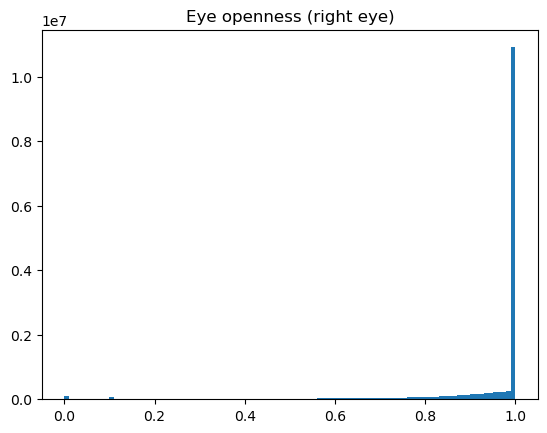

In [33]:
plt.hist(df_validData.eyeOpennessRight, bins=100)
print('Mean:',np.mean(df_validData.eyeOpennessRight))
print('SD:',np.std(df_validData.eyeOpennessRight))
print('Max:',max(df_validData.eyeOpennessRight))
print('Min:',min(df_validData.eyeOpennessRight))
plt.title('Eye openness (right eye)')
plt.show()


Mean: 3.7168899102970774
SD: 0.5544195093968077
Max: 7.750595092773437
Min: 0.040618896484375


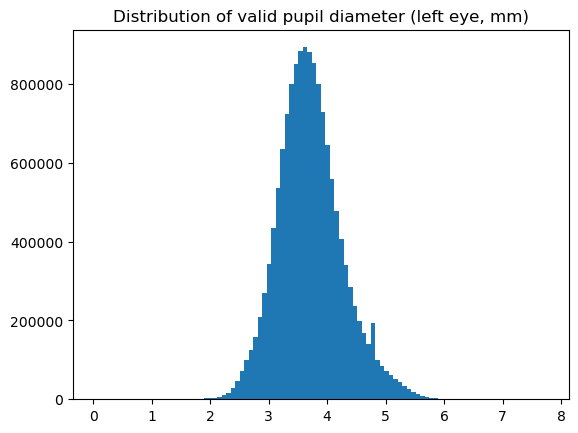

In [35]:
plt.hist(df_validData.pupilDiameterMillimetersLeft, bins=100)
print('Mean:',np.mean(df_validData.pupilDiameterMillimetersLeft))
print('SD:',np.std(df_validData.pupilDiameterMillimetersLeft))
print('Max:',max(df_validData.pupilDiameterMillimetersLeft))
print('Min:',min(df_validData.pupilDiameterMillimetersLeft))
plt.title('Distribution of valid pupil diameter (left eye, mm)')
plt.show()

Mean: 3.751302352612798
SD: 0.5727639848019873
Max: 7.5102691650390625
Min: 0.430328369140625


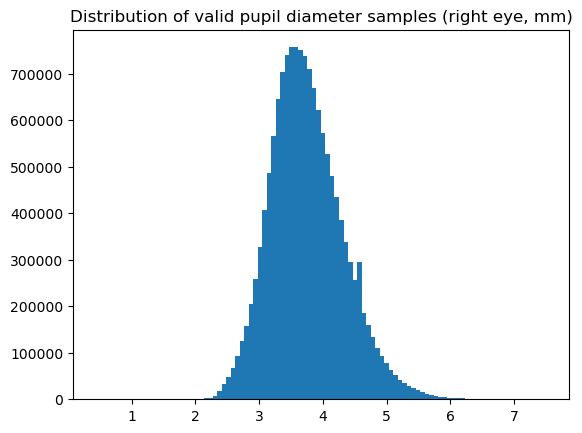

In [36]:
plt.hist(df_validData.pupilDiameterMillimetersRight, bins=100)
print('Mean:',np.mean(df_validData.pupilDiameterMillimetersRight))
print('SD:',np.std(df_validData.pupilDiameterMillimetersRight))
print('Max:',max(df_validData.pupilDiameterMillimetersRight))
print('Min:',min(df_validData.pupilDiameterMillimetersRight))
plt.title('Distribution of valid pupil diameter samples (right eye, mm)')
plt.show()

In [37]:
df_validData.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/Experiment_1_OpenEyes.cvs")